# Explore here

In [2]:
import pandas as pd
from utils import db_connect
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Establecer la conexión a la base de datos
engine = db_connect()

# Verificar si la conexión es exitosa
#if engine:
    #print("Conexión exitosa")

# Consultar la tabla en la base de datos y crear un DataFrame
data = pd.read_sql_table('tabla seguro', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [4]:
data.shape

(1338, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [7]:
data.isnull().any().any()

False

In [8]:
data.duplicated().sum()
fila_duplicada = data[data.duplicated()]
fila_duplicada

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.56


In [9]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.00,39.22,14.04,18.00,27.00,39.00,51.00,64.00
bmi,1337.00,30.66,6.10,15.96,26.29,30.40,34.70,53.13
children,1337.00,1.10,1.21,0.00,0.00,1.00,2.00,5.00
charges,1337.00,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43


In [11]:
# Usamos pd.factorize para codificar las columnas para preservar el orden de las categorias, 
# a diferencia de LabelEncoder, que usa menos memoria pero no mantiene el orden de las categorias.

# Nos decidimos por esta forma ya que tenemos pocas categorías distintas, y pd.factorize
# devuelve tanto los códigos numéricos como las categorías originales, lo que puede ser útil para futuros análisis.

data["sex_num"] = pd.factorize(data["sex"])[0]
data["smoker_num"] = pd.factorize(data["smoker"])[0]
data["region_num"] = pd.factorize(data["region"])[0]

data.head()



,age,sex,bmi,children,smoker,region,charges,sex_num,smoker_num,region_num
0,19,female,27.90,0,yes,southwest,16884.92,0,0,0
1,18,male,33.77,1,no,southeast,1725.55,1,1,1
2,28,male,33.00,3,no,southeast,4449.46,1,1,1
3,33,male,22.70,0,no,northwest,21984.47,1,1,2
4,32,male,28.88,0,no,northwest,3866.86,1,1,2


In [12]:
data_num = data[["age", "bmi", "children", "sex_num", "smoker_num", "region_num", "charges"]].copy() # .copy() para crear dataframe independiente al original
data_num.corr()

# Vemos que apenas hay correlacion entre la región y la prima de seguro, algo normal,
#  * ya que si bien una region puede tener una tendencia hacia una característica influyente mayor que la otra, no tiene que verse reflejada
#  * en todos los sujetos de dicha zona, por lo que sería injusto que, por ejemplo, su prima aumentase por proceder de una zona con mayor 
#  * índice de fumadores, a pesar de que el sujeto concreto no haya fumado en su vida.
# Lo mismo ocurre en relación al sexo.

# Por tanto, eliminaremos las variables.

,age,bmi,children,sex_num,smoker_num,region_num,charges
age,1.00,0.11,0.04,-0.02,0.03,-0.00,0.30
bmi,0.11,1.00,0.01,0.05,-0.00,-0.16,0.20
children,0.04,0.01,1.00,0.02,-0.01,-0.02,0.07
sex_num,-0.02,0.05,0.02,1.00,-0.08,-0.00,0.06
smoker_num,0.03,-0.00,-0.01,-0.08,1.00,-0.00,-0.79
region_num,-0.00,-0.16,-0.02,-0.00,-0.00,1.00,0.01
charges,0.30,0.20,0.07,0.06,-0.79,0.01,1.00


Edad y Costos: Hay una correlación positiva moderada entre la edad y los costos médicos. Esto sugiere que a medida que la edad aumenta, es probable que los costos médicos también aumenten, lo cual es razonable ya que las personas mayores tienden a tener más problemas de salud y pueden requerir más atención médica.

IMC (BMI) y Costos: Existe una correlación positiva leve entre el índice de masa corporal (IMC) y los costos médicos. Esto indica que las personas con un IMC más alto tienden a tener costos médicos ligeramente más altos. Sin embargo, la correlación no es muy fuerte.

Fumadores y Costos: La correlación entre el hecho de ser fumador y los costos médicos es bastante alta y negativa. Esto sugiere que los fumadores tienden a tener costos médicos mucho más altos en comparación con los no fumadores. Esta es una observación significativa y coherente con la literatura médica, ya que el hábito de fumar está asociado con una variedad de problemas de salud.

Región y Costos: La correlación entre la región y los costos médicos es muy baja, lo que indica que la región donde reside una persona tiene una influencia mínima en sus costos médicos.

Sexo y Costos: La correlación entre el sexo y los costos médicos es muy baja, lo que indica que no hay una relación significativa entre el sexo de una persona y sus costos médicos.

En resumen, la edad, el IMC y el hábito de fumar parecen ser los factores más influyentes en los costos médicos, según esta matriz de correlación.

In [13]:
data.drop(['region', 'region_num', 'sex', 'sex_num'], axis=1, inplace=True)
data_num.drop(['region_num', 'sex_num'], axis=1, inplace=True)
data.head()

,age,bmi,children,smoker,charges,smoker_num
0,19,27.90,0,yes,16884.92,0
1,18,33.77,1,no,1725.55,1
2,28,33.00,3,no,4449.46,1
3,33,22.70,0,no,21984.47,1
4,32,28.88,0,no,3866.86,1


In [14]:
#  Buscar valores atípicos (y ver si corresponderia tambien consultar la influencia), antes de elegir el método de escalado

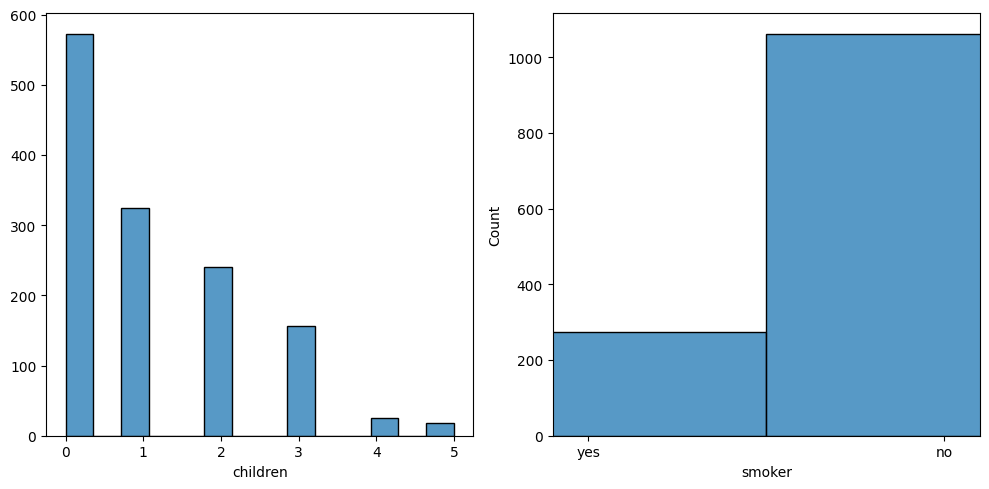

In [15]:
# Análisis ded variables univariantes (categóricas)

fig, axis = plt.subplots(1, 2, figsize = (10, 5))

# Crear un histograma múltiple
sns.histplot(ax = axis[0], data = data, x = "children").set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = "smoker").set_xlim(-0.1, 1.1)


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

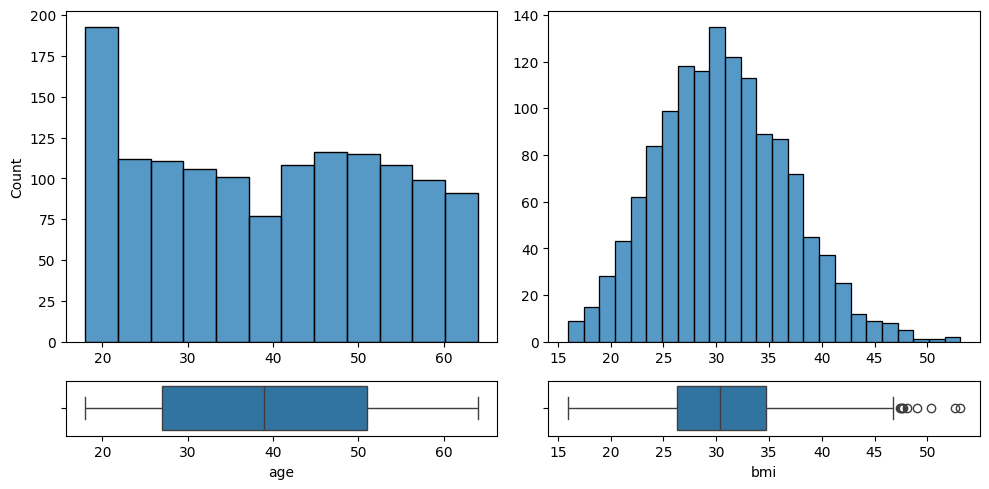

In [16]:
# Análisis sobre variables numéricas

fig, axis = plt.subplots(2, 2, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0, 0], data = data, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "age")
sns.histplot(ax = axis[0, 1], data = data, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "bmi")

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

<Axes: xlabel='charges'>

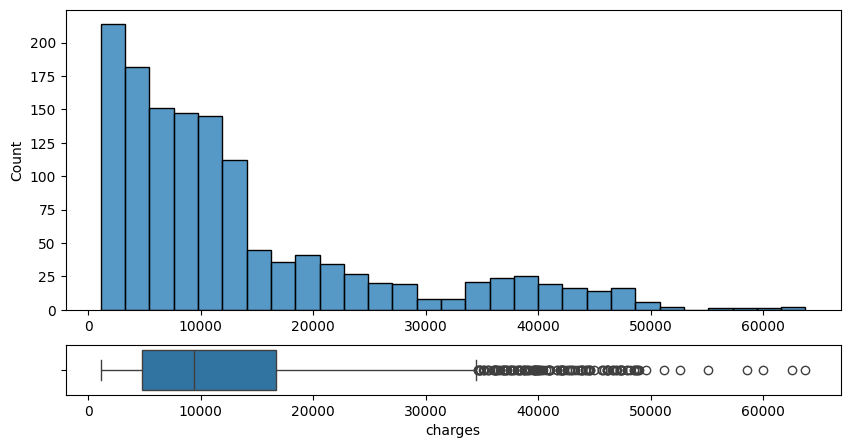

In [17]:
fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges")

<Axes: xlabel='charges_log'>

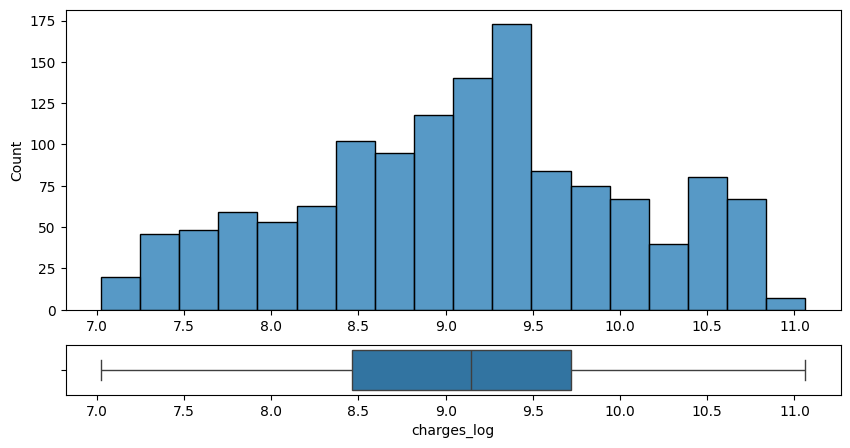

In [18]:
data['charges_log'] = np.log(data.charges)

fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges_log").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges_log")

In [19]:
data.head()

,age,bmi,children,smoker,charges,smoker_num,charges_log
0,19,27.90,0,yes,16884.92,0,9.73
1,18,33.77,1,no,1725.55,1,7.45
2,28,33.00,3,no,4449.46,1,8.40
3,33,22.70,0,no,21984.47,1,10.00
4,32,28.88,0,no,3866.86,1,8.26


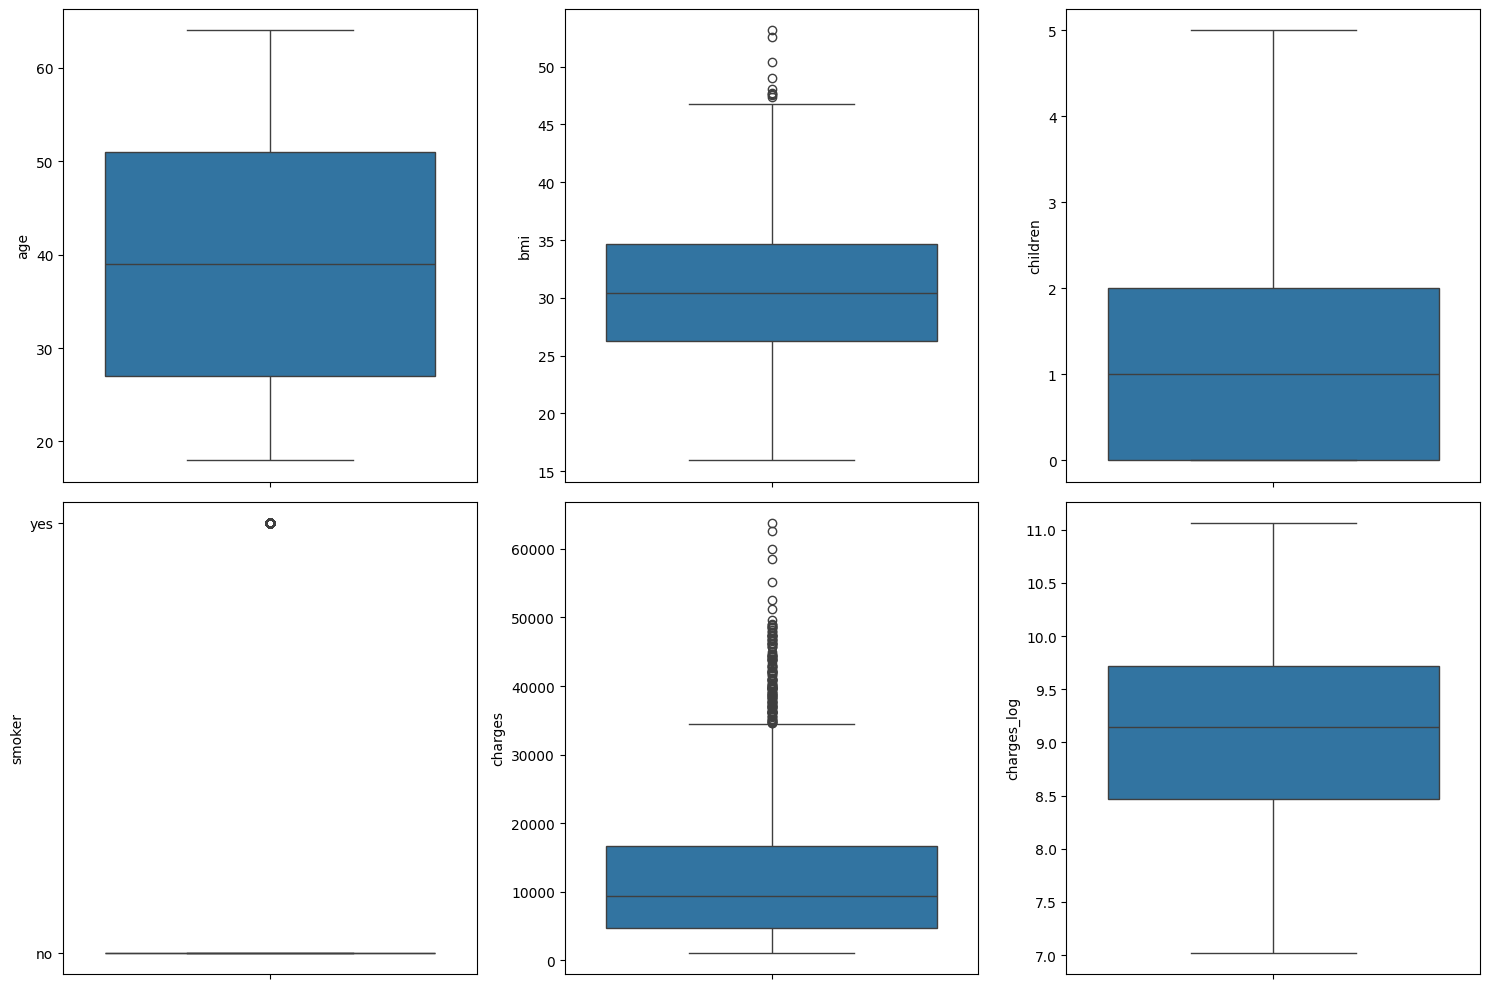

In [20]:
fig, axis = plt.subplots(2, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = data, y = "age")
sns.boxplot(ax = axis[0, 1], data = data, y = "bmi")
sns.boxplot(ax = axis[0, 2], data = data, y = "children")
sns.boxplot(ax = axis[1, 0], data = data, y = "smoker")
sns.boxplot(ax = axis[1, 1], data = data, y = "charges")
sns.boxplot(ax = axis[1, 2], data = data, y = "charges_log")


plt.tight_layout()

plt.show()

In [21]:
data[['bmi', 'charges', 'charges_log']].describe()

,bmi,charges,charges_log
count,1337.00,1337.00,1337.00
mean,30.66,13279.12,9.10
std,6.10,12110.36,0.92
min,15.96,1121.87,7.02
25%,26.29,4746.34,8.47
50%,30.40,9386.16,9.15
75%,34.70,16657.72,9.72
max,53.13,63770.43,11.06


In [22]:
bmi_stats = data['bmi'].describe()

bmi_iqr = bmi_stats["75%"] - bmi_stats["25%"]
upper_limit = bmi_stats["75%"] + 1.5 * bmi_iqr
lower_limit = bmi_stats["25%"] - 1.5 * bmi_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(bmi_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 47.32 y 13.67, con un rango intercuartílico de 8.41


In [23]:
total = (data['bmi'] > 47).sum()
print(f"{((data['bmi'] > 47).sum()) / len(data['bmi']) * 100}%")


0.6731488406881078%


In [24]:
data[data["bmi"] > 47]

# Podríamos eliminar los outlayers de bmi porque suponen un porcentaje muy pequeño, pero sumado al análisis univariante anterior,
# existe una implicación entre el precio del seguro y el índice de masa corporal, por lo que mantenemos los valores atípicos

,age,bmi,children,smoker,charges,smoker_num,charges_log
116,58,49.06,0,no,11381.33,1,9.34
286,46,48.07,2,no,9432.93,1,9.15
401,47,47.52,1,no,8083.92,1,9.00
543,54,47.41,0,yes,63770.43,0,11.06
846,23,50.38,1,no,2438.06,1,7.80
859,37,47.60,2,yes,46113.51,0,10.74
1046,22,52.58,1,yes,44501.40,0,10.70
1087,52,47.74,1,no,9748.91,1,9.18
1316,18,53.13,0,no,1163.46,1,7.06


In [25]:
data_num['charges_log'] = np.log(data_num.charges)
data_num.head()

,age,bmi,children,smoker_num,charges,charges_log
0,19,27.90,0,0,16884.92,9.73
1,18,33.77,1,1,1725.55,7.45
2,28,33.00,3,1,4449.46,8.40
3,33,22.70,0,1,21984.47,10.00
4,32,28.88,0,1,3866.86,8.26


In [26]:
# Variables independientes/dependiente
X = data_num.drop(['charges', 'charges_log'], axis=1)
y = data_num['charges_log']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

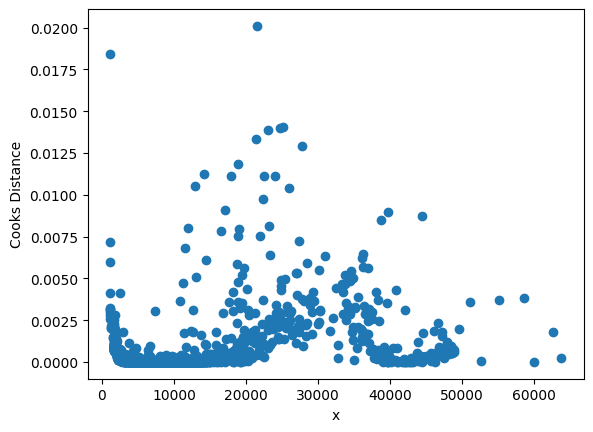

In [27]:
plt.scatter(data_num.charges, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

Si al calcular y graficar la distancia de Cook obtienes un scatter plot que parece una nube dispersa en lugar de una línea alrededor del cero con algunos puntos fuera, significa que no hay puntos de datos particularmente influyentes en tu modelo de regresión. En otras palabras, no hay valores atípicos o puntos que tengan un impacto desproporcionado en los coeficientes de regresión del modelo.

Cuando la distancia de Cook produce una dispersión difusa en lugar de puntos claramente fuera de la línea, puede haber varias razones:

No hay valores atípicos influyentes: En algunos conjuntos de datos, todos los puntos pueden tener una influencia similar en el modelo, lo que resulta en una dispersión uniforme alrededor del cero en el gráfico de distancia de Cook. Esto sugiere que no hay valores atípicos o puntos influyentes que distorsionen significativamente los resultados del modelo.

Robustez del modelo: Algunos modelos de regresión pueden ser inherentemente más robustos ante valores atípicos que otros. Si tu modelo es robusto o si has utilizado técnicas de estimación robustas, es menos probable que los valores atípicos influyan en gran medida en los resultados.

Bajo poder para detectar valores atípicos: En conjuntos de datos pequeños o con pocos predictores, puede ser más difícil detectar valores atípicos utilizando la distancia de Cook. En tales casos, la capacidad del análisis para identificar valores atípicos puede verse limitada.

En resumen, una dispersión difusa en el gráfico de distancia de Cook sugiere que tu modelo de regresión puede ser robusto y que no hay puntos de datos que tengan un impacto desproporcionado en los resultados del modelo. Esto puede ser una señal positiva en términos de la calidad y la fiabilidad del modelo.

In [28]:
out = np.where(cooks_distance[0]>0.0175)
d_out = data_num.iloc[out]

# A pesar de que nustro análisis de cook nos dio una 'nube', si podemos observar dos valores claramente por encima.
# Ambos sujetos son muy jovenes, sin niños y no fumadores.

# Teniendo en cuenta nos basamos en seguros, la juventud suele influír positivamente, pero si es muy joven puede ocurrir lo contrario,
# * ya que las compañias de seguros suelen tener en cuenta la mayor temeridad e irresponsabilidad en los sujetos más jovenes.

# Vemos que el sujeto 1316, tiene el mínimo de edad, pero es el máximo del conjuto en cuanto a bmi, muy por encima de la media, sin embargo,
# * tiene una cuota más barata. Esto puede deberse a un físico anormalmente trabajado, lo que tanto por génetica como por ejercicio, se puede traducir
# * en una salud mejor, y por tanto paga menos.

# El sujeto 1026, aunque a priori la edad le favorecería, ya que es joven pero ya pasa los 20 años, tiene un bmi muy bajo, casi al mínimo,
# * y muy por debajo de la media y del percentil 25%. De esto se deduce que su forma física no es óptima, y por eso su seguro es más caro que es de su análogo.

# Por tanto, como estamos modelizando, eliminaremos estas dos filas de nuestros datos, ya que son sujetos "poco normativos" y que por tanto
# * no representan al grueso de la poblacion, además de que tienen influencia en el modelo.

In [29]:
data_num.drop(d_out.index, axis=0, inplace=True)
data_num.reset_index(drop=True, inplace=True)
data_num.head()

,age,bmi,children,smoker_num,charges,charges_log
0,19,27.90,0,0,16884.92,9.73
1,18,33.77,1,1,1725.55,7.45
2,28,33.00,3,1,4449.46,8.40
3,33,22.70,0,1,21984.47,10.00
4,32,28.88,0,1,3866.86,8.26


In [30]:
data.isnull().any().any()

False

In [31]:
data_num.apply(lambda x: x.skew())

age            0.05
bmi            0.26
children       0.94
smoker_num    -1.46
charges        1.52
charges_log   -0.09
dtype: float64

In [32]:
# La windsorización puede ser útil para suavizar los efectos de los valores atípicos en los datos
# y mejorar la capacidad predictiva del modelo de regresión lineal.

# Seleccionamos las columnas no binarias
binarias = data_num[['smoker_num']]
data_wind = data_num.drop(binarias, axis=1)

# Función para calcular IQR y aplicar winsorización
def winsorize_column(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Calcular el IQR y aplicar winsorización a cada columna
for column in data_wind.columns:
    data_wind[column] = winsorize_column(data_wind[column], 0.25, 0.75)

In [33]:
data_wind.apply(lambda x: x.skew())

age            0.05
bmi            0.23
children       0.94
charges        1.08
charges_log   -0.09
dtype: float64

In [34]:
data_p = pd.concat([data_wind, binarias], axis=1)

In [35]:
data_p.head()

,age,bmi,children,charges,charges_log,smoker_num
0,19,27.90,0,16884.92,9.73,0
1,18,33.77,1,1725.55,7.45,1
2,28,33.00,3,4449.46,8.40,1
3,33,22.70,0,21984.47,10.00,1
4,32,28.88,0,3866.86,8.26,1


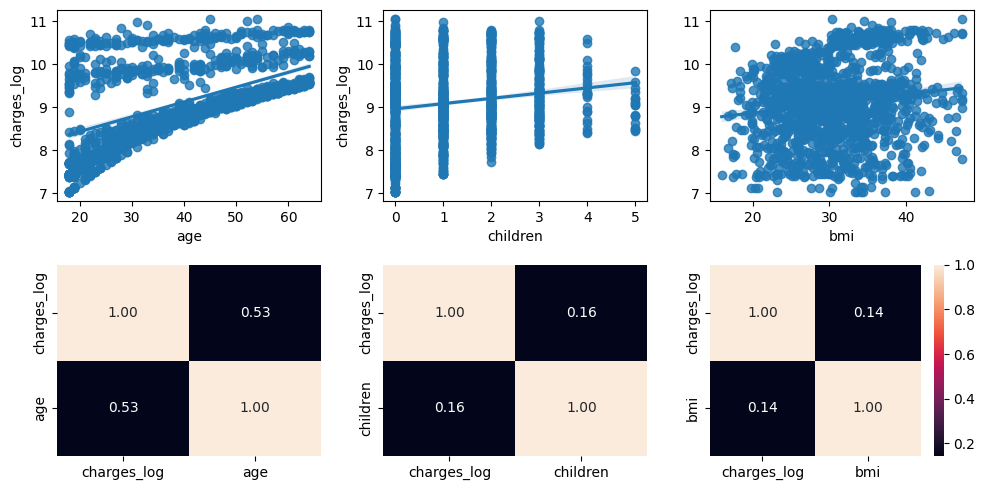

In [36]:
fig, axis = plt.subplots(2, 3, figsize = (10, 5))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = data_p, x = "age", y = "charges_log")
sns.heatmap(data_p[["charges_log", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = data_p, x = "children", y = "charges_log")
sns.heatmap(data_p[["charges_log", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)
sns.regplot(ax = axis[0, 2], data = data_p, x = "bmi", y = "charges_log").set(ylabel=None)
sns.heatmap(data_p[["charges_log", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 2])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

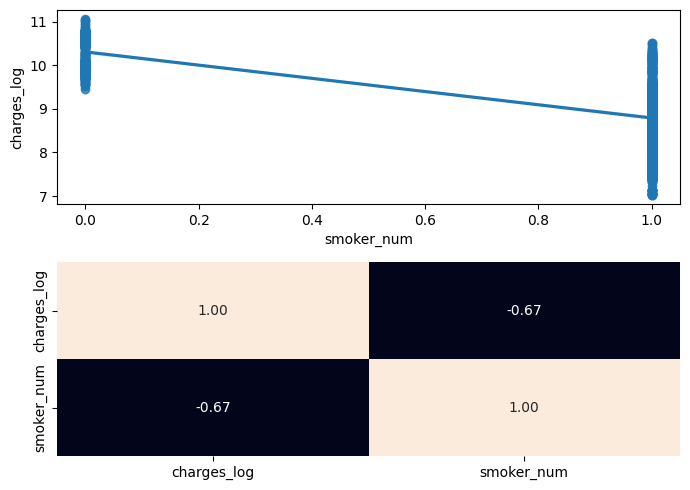

In [37]:
fig, axis = plt.subplots(2, 1, figsize = (7, 5))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0], data = data, x = "smoker_num", y = "charges_log")
sns.heatmap(data[["charges_log", "smoker_num"]].corr(), annot = True, fmt = ".2f", ax = axis[1], cbar = False)


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

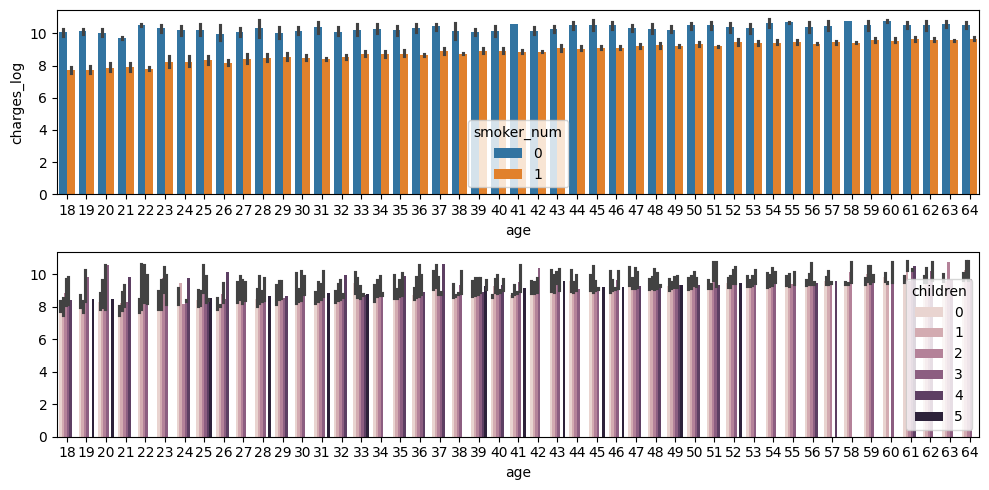

In [38]:
fig, axis = plt.subplots(2, 1, figsize = (10, 5))

sns.barplot(ax = axis[0], data = data_p, x = "age", y = "charges_log", hue = "smoker_num")
sns.barplot(ax = axis[1], data = data_p, x = "age", y = "charges_log", hue = "children").set(ylabel = None)

plt.tight_layout()

plt.show()

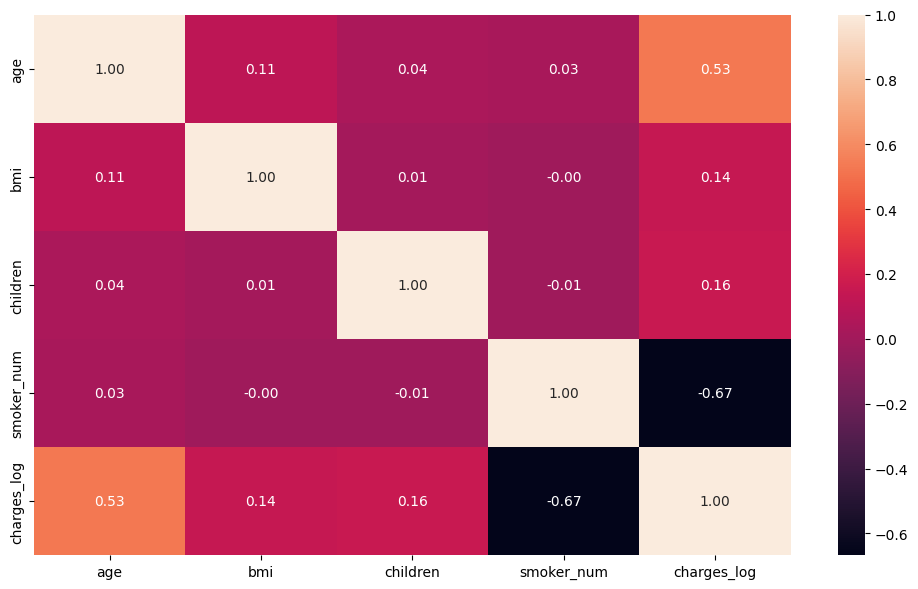

In [39]:
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(data_p[["age", "bmi", "children", "smoker_num", "charges_log"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

# En principio observamos una correlacion bastante fuerte entre la edad y ser fumador con el precio del seguro.
# El índice de masa corporal y el numero de niños a cargo no parecen influír demasiado en el precio.

In [40]:
data_p[['age', 'children']].corr()

,age,children
age,1.00,0.04
children,0.04,1.00


Categorización del IMC - hay que tener en cuenta que el imc no tiene en cuenta la composición corporal, es decir,
si tu peso se debe a un mayor contenido en grasa o en músculo, cosa relevante ya que el músculo pesa más que la grasa, y un mayor porcentaje de musculo se relaciona con una salud más robusta, por lo que un imc muy alto puede deberse tanto a una situación de obesidad, como a un físico muy musculado. 

De hecho, como se mencionó anteriormente, el músculo pesa más que la grasa, por lo que a mayor desarrollo de la musculatura, el efecto en el peso, y por tanto el IMC, va a impactar más que en el caso de la acumulación de grasa.

Esto explica la baja correlacion entre el IMC y la prima de seguro, y por tanto, decidimos no categorizar el IMC según la tabla de la OMS,
ya que no son datos de valor. 

Por ejemplo, en los valores atípicos observados anteriormente, nos encontrabamos con un sijeto de 18 años con un IMC de 50, lo cual es muy elevado.
Si nos guíasemos por la tabla de la OMS, este sujeto se categorizaria como "Obesidad clase III", y sin embargo, observabamos que tenía una prima de seguro más baja que el otro sujeto atípico, que se encontraba en el límite del 'peso normal', siendo la variable edad poco relevante ya que solo se llevaban 5 años de diferencia y ambos eran muy jóvenes, por lo que podríamos deducir que el alto IMC del sujeto de 18 años se debe a una musculatura más desarrollada y no a una situación de obesidad severa.

In [41]:
# Categorización de la edad

# 1 - muy joven
# 2 - joven
# 3 - mediana edad
# 4 - anciano

def rango_edad(edad):
  if edad <= 25: return 1
  elif 26 <= edad <= 45: return 2
  elif 46 <= edad <= 70: return 3
  else: return 4

data_p['r_edad'] = data_p.age.apply(rango_edad)
data_p

,age,bmi,children,charges,charges_log,smoker_num,r_edad
0,19,27.90,0,16884.92,9.73,0,1
1,18,33.77,1,1725.55,7.45,1,1
2,28,33.00,3,4449.46,8.40,1,2
3,33,22.70,0,21984.47,10.00,1,2
4,32,28.88,0,3866.86,8.26,1,2
...,...,...,...,...,...,...,...
1330,50,30.97,3,10600.55,9.27,1,3
1331,18,31.92,0,2205.98,7.70,1,1
1332,18,36.85,0,1629.83,7.40,1,1
1333,21,25.80,0,2007.94,7.60,1,1


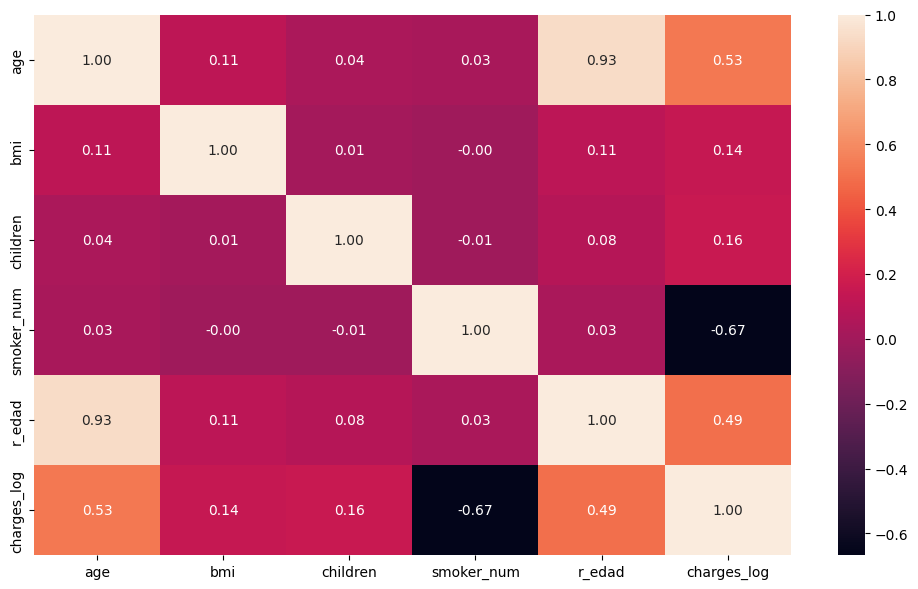

In [42]:
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(data_p[["age", "bmi", "children", "smoker_num", "r_edad", "charges_log"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

In [43]:
corr = data_p.corr()
corr[corr.charges_log.abs()<0.2].index

Index(['bmi', 'children'], dtype='object')

In [44]:
corr[corr.charges_log.abs()>0.5].index

Index(['age', 'charges', 'charges_log', 'smoker_num'], dtype='object')

In [45]:
# Factor de inflación de la varianza - análisis de la multicolinealidad

vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=data_p.columns)
vif

age            285.44
bmi              2.26
children         4.10
charges        907.30
charges_log   1045.53
smoker_num      45.93
r_edad         233.97
dtype: float64

In [46]:
data_p.drop(['charges', 'r_edad'], axis=1, inplace=True)

In [47]:
corr = data_p.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=data_p.columns)
vif

age           16.27
bmi            1.28
children       1.74
charges_log   56.82
smoker_num    28.73
dtype: float64

In [48]:
X = data_p.drop(['charges_log'], axis=1)
y = data_p['charges_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Consulta importancia de las características

model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

feature_importances = model.feature_importances_   # Calcula la importancia de las características

feature_names = X.columns      # Asocia las importancias con los nombres de las características
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Ordena las características por importancia (de mayor a menor)
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance*100}')

Feature: smoker_num, Importance: 87.0326042175293
Feature: age, Importance: 7.341381907463074
Feature: children, Importance: 3.9696745574474335
Feature: bmi, Importance: 1.6563378274440765


In [50]:
# Escalado de valores

escalar_variables = ["age", "bmi", "children"]

scaler = MinMaxScaler()

escalado = scaler.fit_transform(data_p[escalar_variables])

data_scaled = pd.DataFrame(escalado, index = data_p.index, columns = escalar_variables)

data_scaled['charges_log'] = data_p['charges_log']
data_scaled['smoker_num'] = data_p['smoker_num']

data_scaled.head()

,age,bmi,children,charges_log,smoker_num
0,0.02,0.38,0.00,9.73,0
1,0.00,0.57,0.20,7.45,1
2,0.22,0.54,0.60,8.40,1
3,0.33,0.22,0.00,10.00,1
4,0.30,0.41,0.00,8.26,1


In [51]:
data_scaled.to_csv("/workspaces/linear-regression/data/processed/datos-procesados.csv", index = False)

In [52]:
linear_data = pd.read_csv("/workspaces/linear-regression/data/processed/datos-procesados.csv")
linear_data.head()

,age,bmi,children,charges_log,smoker_num
0,0.02,0.38,0.00,9.73,0
1,0.00,0.57,0.20,7.45,1
2,0.22,0.54,0.60,8.40,1
3,0.33,0.22,0.00,10.00,1
4,0.30,0.41,0.00,8.26,1


In [53]:
X = linear_data.drop(['charges_log'], axis=1)
y = linear_data['charges_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

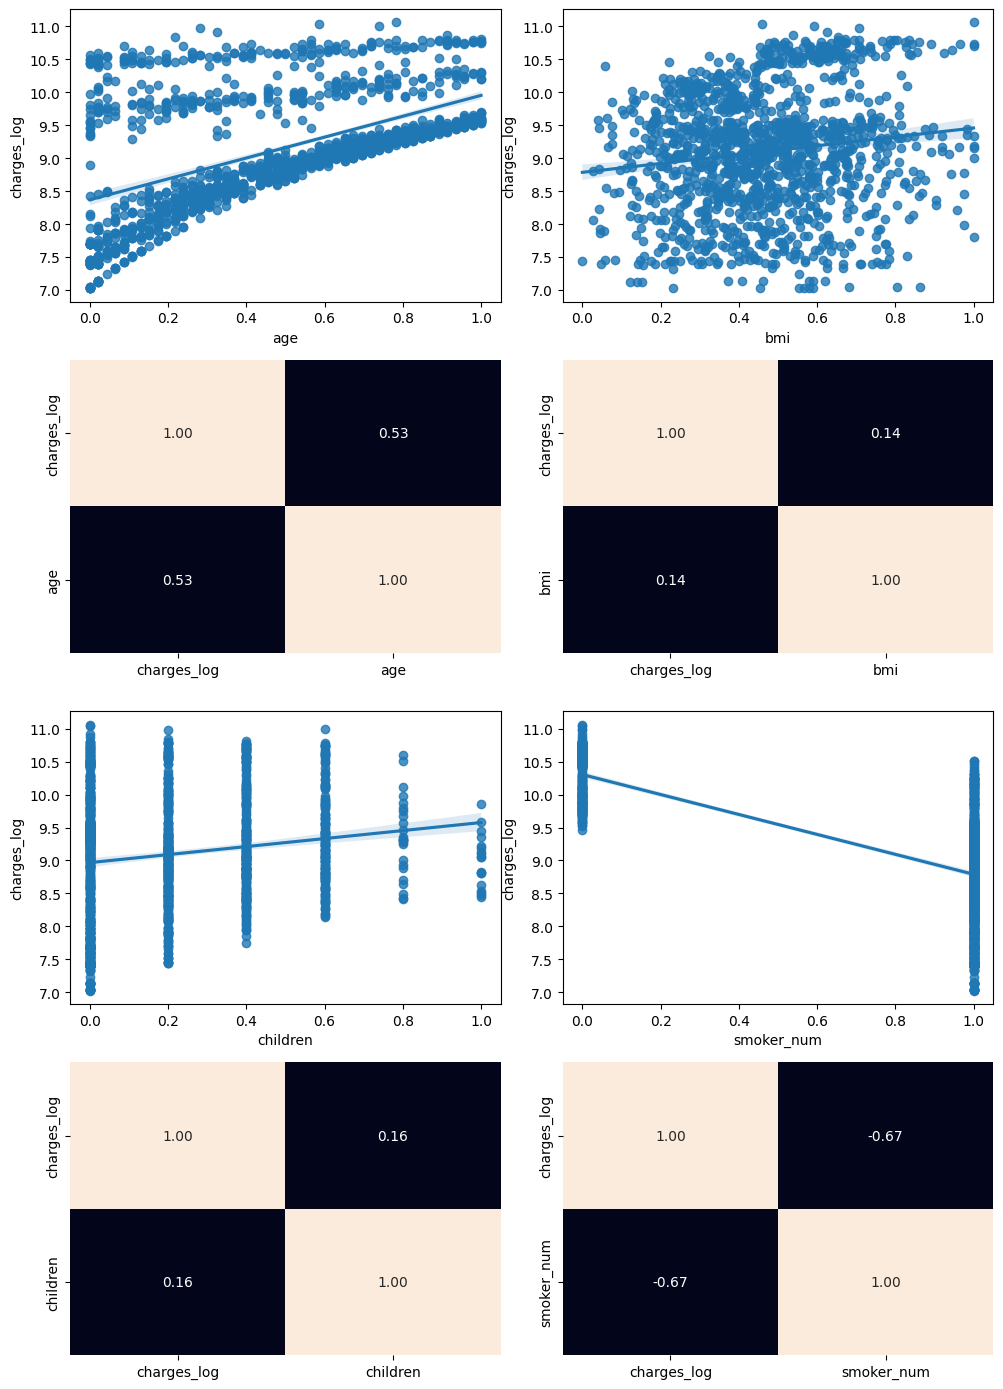

In [54]:

fig, axis = plt.subplots(4, 2, figsize = (10, 14))

sns.regplot(data = linear_data, x = "age", y = "charges_log", ax = axis[0, 0])
sns.heatmap(linear_data[["charges_log", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(data = linear_data, x = "bmi", y = "charges_log", ax = axis[0, 1])
sns.heatmap(linear_data[["charges_log", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)

sns.regplot(data = linear_data, x = "children", y = "charges_log", ax = axis[2, 0])
sns.heatmap(linear_data[["charges_log", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0], cbar = False)

sns.regplot(data = linear_data, x = "smoker_num", y = "charges_log", ax = axis[2, 1])
sns.heatmap(linear_data[["charges_log", "smoker_num"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1], cbar = False)

plt.tight_layout()
plt.show()

In [55]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:02<00:00, 14.13it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 1068, number of used features: 4
[LightGBM] [Info] Start training from score 9.085025


In [56]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.85       0.85  0.36        0.15
SVR                                          0.84       0.84  0.37        0.04
NuSVR                                        0.84       0.84  0.37        0.13
HistGradientBoostingRegressor                0.83       0.83  0.38        0.24
LGBMRegressor                                0.82       0.82  0.39        0.04
KNeighborsRegressor                          0.80       0.81  0.41        0.01
BaggingRegressor                             0.80       0.80  0.41        0.03
TransformedTargetRegressor                   0.80       0.80  0.41        0.01
LinearRegression                             0.80       0.80  0.41        0.01
OrthogonalMatchingPursuitCV                  0.80       0.80  0.41        0.02
LassoLarsIC                                  0.80   

In [57]:
# Crear y entrenar el modelo SVR
svr = SVR(kernel='rbf')  # El kernel 'rbf' es comúnmente utilizado para SVR
svr.fit(X_train, y_train)

SVR()

In [58]:
# Realizar predicciones en el conjunto de prueba
y_pred = svr.predict(X_test)


In [59]:
y_pred

array([ 7.52906276,  8.66297799,  8.77672358, 10.48724644,  8.48489816,
        9.24004781, 10.58810329,  7.69605054,  8.91807543, 10.78968976,
        9.52940025, 10.24659766,  7.51069986,  9.56869992,  8.66361537,
        9.0917371 ,  7.79298101, 10.58647323,  8.6278088 ,  8.26899089,
        7.57499934,  8.54727007,  9.23811797, 10.11509499, 10.08129178,
        8.10425346,  8.4821995 ,  7.99478249,  9.16949316,  9.34672007,
        8.21082455,  8.92986724,  9.47248381,  9.53151994, 10.66863588,
        8.13574666,  8.56688792, 10.60209942,  9.02769466,  9.0566103 ,
        7.67914677,  9.50765625, 10.6393314 ,  8.34826655,  9.13464451,
        8.05638588,  8.90138155,  9.43838433,  8.2285369 ,  9.22076048,
        8.38902097,  8.61841358,  9.56808386,  7.57473004,  9.42530119,
        9.05309134,  7.81285732,  8.06806308, 10.41540822,  8.93874588,
        9.37781692,  8.77385065,  9.34543133,  7.80114592,  9.96402365,
        8.88115387,  8.68072878,  9.17014563,  9.85901566,  9.61

In [60]:
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Un MSE más bajo indica un mejor ajuste del modelo a los datos de prueba.

Mean Squared Error: 0.13477918361564192


In [61]:
# Calcular la varianza de los datos reales
varianza = np.var(y_test)

# Calcular el rango de los valores reales
rango = np.max(y_test) - np.min(y_test)

print("Varianza:", varianza)
print("Rango:", rango)

if mse < varianza:
    print("El MSE es significativamente menor que la varianza de los datos reales.")
elif mse < rango:
    print("El MSE es significativamente menor que el rango de los valores reales.")
else:
    print("El MSE no es significativamente menor que la varianza ni el rango de los valores reales.")

print("Esto indica que el modelo está capturando bien la variabilidad en los datos y haciendo predicciones con precisión.")

Varianza: 0.863117605236844
Rango: 3.824886645085665
El MSE es significativamente menor que la varianza de los datos reales.
Esto indica que el modelo está capturando bien la variabilidad en los datos y haciendo predicciones con precisión.


In [62]:
# Invierte la transformación de MinMaxScaler para las características escaladas
X_test_inverse = scaler.inverse_transform(X_test[['age', 'bmi', 'children']])  
X_test_inverse_df = pd.DataFrame(X_test_inverse, columns=['age', 'bmi', 'children'])  # Crea un DataFrame con las características escaladas invertidas
X_test_inverse_df['smoker_num'] = X_test['smoker_num']  # Añade la columna binaria sin escalar

# Invierte la transformación logarítmica de las predicciones y los datos de prueba
y_pred_inverse = np.exp(y_pred)
y_test_inverse = np.exp(y_test)

# Calcula el MSE en la escala original de los datos
mse_original = mean_squared_error(y_test_inverse, y_pred_inverse)
print("Mean Squared Error (Original Scale):", mse_original)

Mean Squared Error (Original Scale): 21702463.108552862


El hecho de que el error cuadrático medio (MSE) en la escala original de los datos sea significativamente mayor que el MSE en la escala de los datos escalados es algo esperable y común. Aquí hay algunas razones para esto:

Escala de los datos: Cuando escalas los datos, se ajustan sus valores para que estén en un rango específico, lo que puede reducir el MSE. Sin embargo, al invertir la escala, los valores vuelven a su rango original, lo que puede hacer que el MSE aumente.

Transformaciones de los datos: También estamos tratando con una variable objetivo que ha sido transformada logarítmicamente. Esto significa que ese está modelando la relación entre las características y el logaritmo de la variable objetivo. Al invertir esta transformación, los errores también se amplificarán, lo que podría contribuir al aumento del MSE.

Sensibilidad a los errores en la escala original: Los errores en la escala original pueden ser más pronunciados debido a la naturaleza de las transformaciones aplicadas a los datos. Esto significa que pequeños errores en la predicción pueden amplificarse cuando se vuelven a escalar a la escala original.

En cuanto a las conclusiones que se pueden extraer:

El hecho de que el MSE en la escala original sea mucho mayor que el MSE en la escala de los datos escalados sugiere que el modelo puede no ser tan preciso cuando se consideran los valores reales de la variable objetivo.

Es importante tener en cuenta que el MSE puede ser sensible a los valores atípicos y a la distribución de los datos. Un MSE alto en la escala original puede indicar que el modelo tiene dificultades para capturar la variabilidad de los datos reales.

Esto resalta la importancia de interpretar el MSE en el contexto de los datos y las transformaciones aplicadas. En algunos casos, un MSE más alto en la escala original puede ser aceptable si el modelo aún proporciona predicciones útiles en términos relativos.

En resumen, es común observar diferencias significativas entre el MSE en la escala de los datos escalados y el MSE en la escala original. Esto subraya la importancia de comprender cómo las transformaciones de los datos afectan la evaluación del rendimiento del modelo.

In [63]:
print(f"R2 Score: {r2_score(y_test, y_pred)}")

R2 Score: 0.8438460960616626


- Interpretación de Resultados:

En escala logarítmica, un MSE de 0.1348 es bajo, sugiriendo que las predicciones están cerca de los valores reales en esta escala transformada.

Un R² score de 0.84 es indicativo de un modelo robusto que explica bien la mayoría de la variabilidad en los datos.


En la escala original, aunque el MSE es 21702463, lo que parece alto, esto debe interpretarse en el contexto de los valores originales (que pueden tener un amplio rango y valores elevados debido a la transformación exponencial).
La comparación con la varianza es crucial para entender la efectividad del modelo. Si el MSE es significativamente menor que la varianza de los datos reales, esto indica un buen ajuste del modelo.

Observando unicamente las cinco primeras filas del dataframe podemos ver que:

* El rango en la muestra de "charges" es considerable, desde 1,725.55 hasta 21,984.47

* El MSE puede parecer alto numéricamente, pero es crucial entender que es el promedio de los errores cuadrados, lo que magnifica los errores más grandes.

Para una mejor interpretación, podríamos calcular la raíz del MSE (RMSE), lo que da una idea del error promedio en las mismas unidades que los datos originales (euros).

In [64]:
# Calcular el MSE en la escala original
mse_original = mean_squared_error(y_test_inverse, y_pred_inverse)
print("Mean Squared Error (Original Scale):", mse_original)

# Calcular RMSE
rmse_original = np.sqrt(mse_original)
print("Root Mean Squared Error (Original Scale):", rmse_original)

Mean Squared Error (Original Scale): 21702463.108552862
Root Mean Squared Error (Original Scale): 4658.590249050979


In [66]:
print(data['charges'].min())
print(data['charges'].max())

1121.8739
63770.42801


RMSE: 4658.59 euros.
Esto significa que, en promedio, las predicciones del modelo se desvían aproximadamente en 4658.59 euros de los valores reales en la escala original.
Dado el rango de los valores originales de "charges" (de 1,121.87 a 63,770.42 euros), este error es relativamente pequeño, aunque sería deseable redicirlo bastante más.

Aunque el MSE parecía grande, el RMSE sugiere que el modelo está haciendo un trabajo razonable al predecir los costos de seguro en la escala original, con un error promedio de alrededor de 4,658.59 euros, lo cual es aceptable considerando los valores de "charges" en los datos.